In [1]:
import importlib

import pandas as pd
import sklearn.cross_decomposition
import sklearn.linear_model
import matplotlib.pyplot as plt
import seaborn

import sp_project.data_preparation.db_entsoe as entsoe_data
import sp_project.data_preparation.db_wetter2 as wetter2_data
from sp_project.data_preparation.solar_power import total_solarpower_below_clouds

%matplotlib inline

/Users/missd/.pyenv/versions/3.10.4/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Collect and prepare the Data

<b>Units:</b><br>
temperature : celsius<br>
rain : mm<br>
wind : m/s<br>
cloud : percent<br>

In [2]:
daily_data = await wetter2_data.extract_data_daily()
heating_demand = await wetter2_data.extract_heatingdemand()
windpower = await wetter2_data.extract_windpower()
solar_power = total_solarpower_below_clouds(daily_data, 47)

In [3]:
input_features = [heating_demand, windpower, daily_data.rain, solar_power.rename("solar_power")]
input_features = pd.concat(input_features, axis="columns")

In [4]:
target_features = await entsoe_data.extract_energy_data_daily()

## Analyse Data with Linear Regression

### Daily Data

In [5]:
valid_input_features_daily = input_features.dropna(axis="index", how='any').index
valid_target_features_daily = target_features.dropna(axis="index", how='any').index
joined_index = valid_input_features_daily.intersection(valid_target_features_daily)

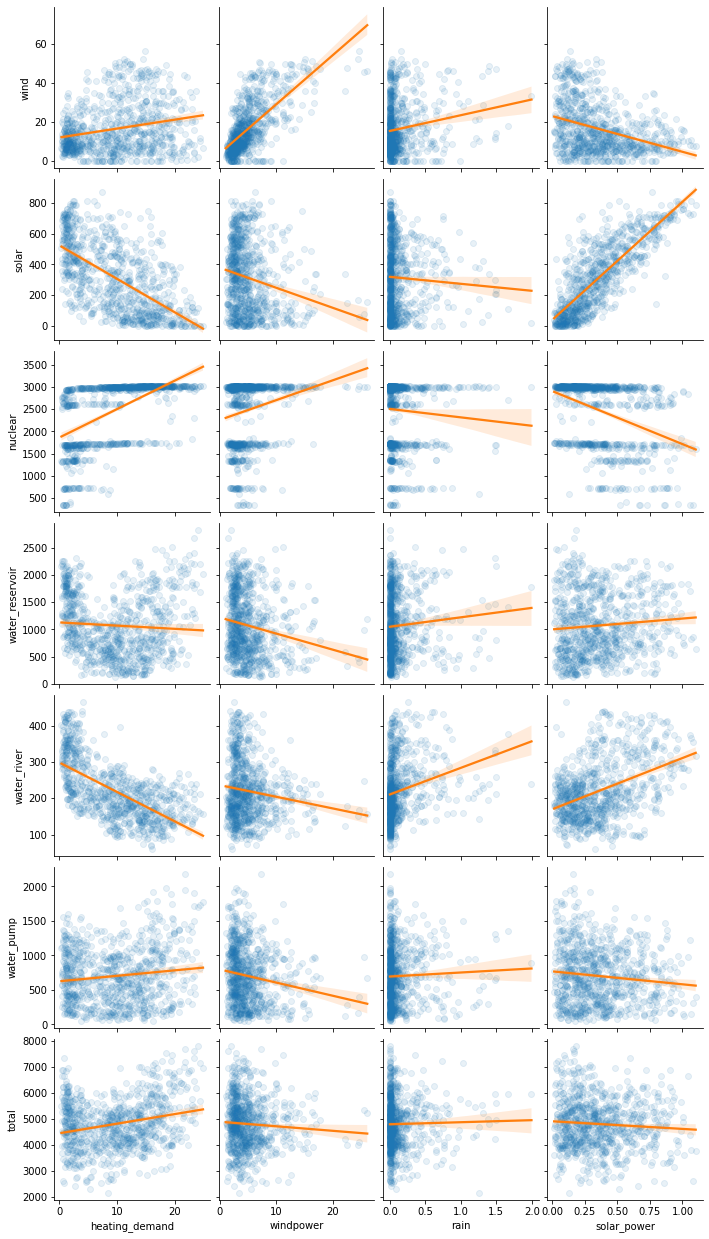

In [6]:
seaborn.pairplot(
    data=pd.concat([input_features, target_features],axis="columns"),
    x_vars=input_features.columns,
    y_vars=target_features.columns,
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(
            color="tab:blue",
            alpha=0.1,
        ),
        line_kws=dict(color='tab:orange'),
    )
)

#### Regression Solar-Energy and Sunshine

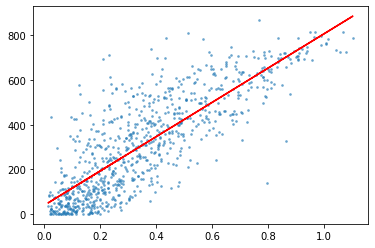

In [7]:
X = input_features.solar_power[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.solar[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

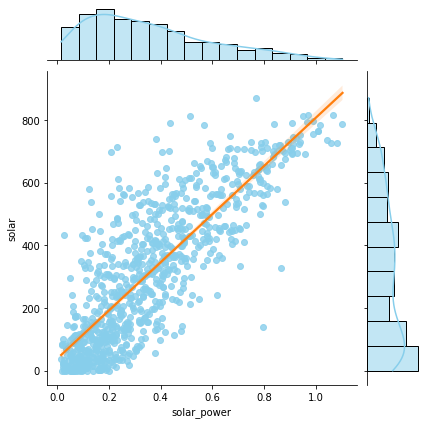

In [8]:
seaborn.jointplot(
    x=input_features.solar_power, 
    y=target_features.solar,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

#### Regression Wind-Energy and Wind

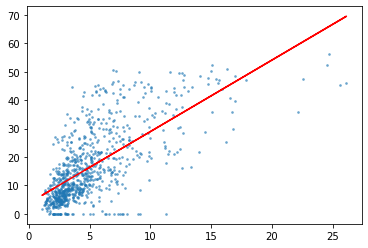

In [9]:
X = input_features.windpower[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.wind[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

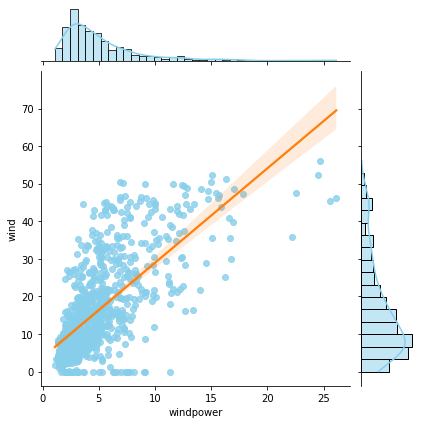

In [10]:
seaborn.jointplot(
    x=input_features.windpower, 
    y=target_features.wind,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

#### Regression Water-River-Energy and Rain

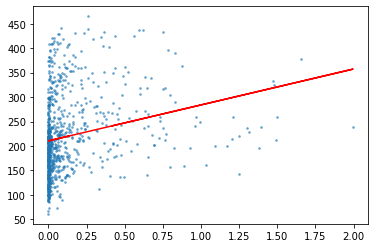

In [11]:
X = input_features.rain[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.water_river[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

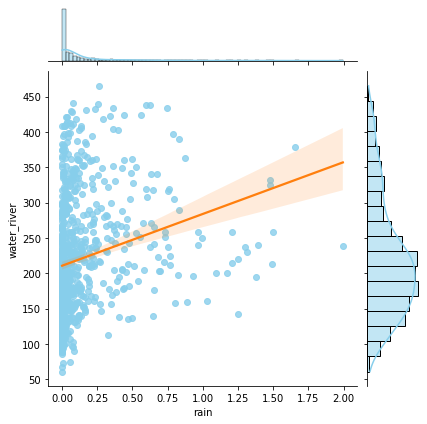

In [12]:
seaborn.jointplot(
    x=input_features.rain, 
    y=target_features.water_river,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

#### Regression Nuclear-Energy and Heating Demand

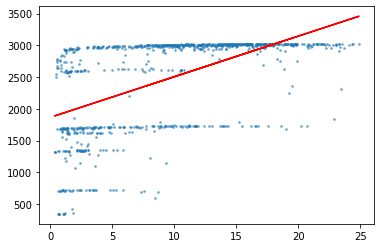

In [13]:
X = input_features.heating_demand[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.nuclear[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

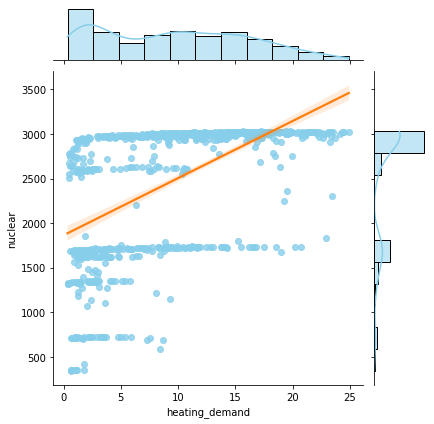

In [14]:
seaborn.jointplot(
    x=input_features.heating_demand, 
    y=target_features.nuclear,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

### Weekly Data

In [15]:
input_features_weekly = input_features.resample('W').mean()
target_features_weekly = target_features.resample('W').mean()

In [16]:
valid_input_features_weekly = input_features.dropna(axis="index", how='any').index
valid_target_features_weekly = target_features.dropna(axis="index", how='any').index

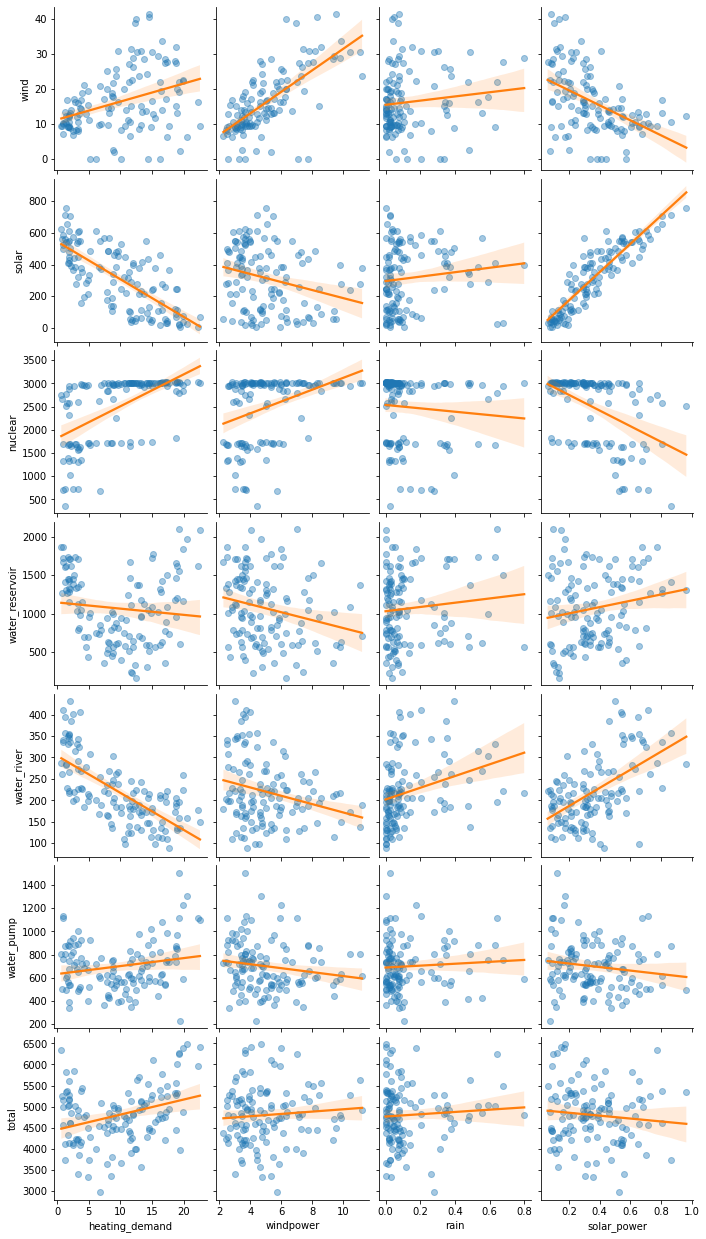

In [17]:
regression_overview = seaborn.pairplot(
    data=pd.concat([input_features_weekly, target_features_weekly],axis="columns"),
    x_vars=input_features_weekly.columns,
    y_vars=target_features_weekly.columns,
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(
            color="tab:blue",
            alpha=0.4,
        ),
        line_kws=dict(color='tab:orange'),
    )
)


In [18]:
regression_overview.savefig("../../src/sp_project/backend_server/static/pictures/regression-overview.png")

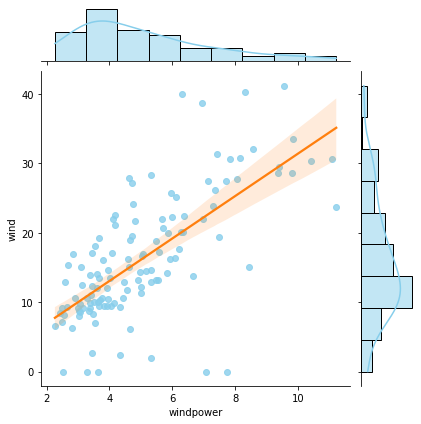

In [20]:
seaborn.jointplot(
    x=input_features_weekly.windpower, 
    y=target_features_weekly.wind,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

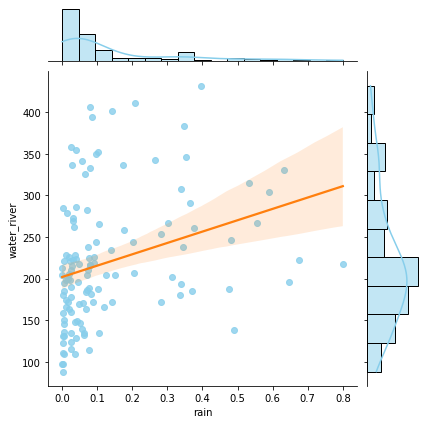

In [21]:
seaborn.jointplot(
    x=input_features_weekly.rain, 
    y=target_features_weekly.water_river,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

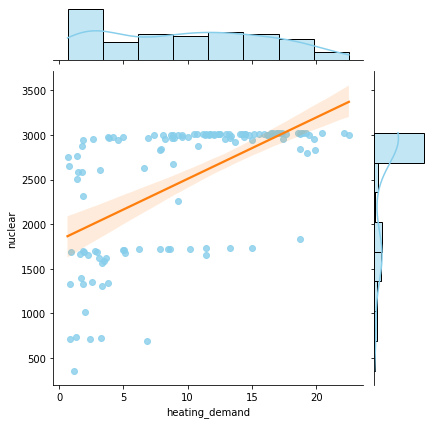

In [22]:
seaborn.jointplot(
    x=input_features_weekly.heating_demand, 
    y=target_features_weekly.nuclear,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

### PLS-Regression with weekly data

In [23]:
input_features_weekly = input_features.resample('W').mean()
target_features_weekly = target_features.resample('W').mean()

valid_input_features_weekly = input_features_weekly.dropna(axis="index", how='any').index
valid_target_features_weekly = target_features_weekly.dropna(axis="index", how='any').index

joined_index = valid_input_features_weekly.intersection(valid_target_features_weekly)
joined_index = joined_index[joined_index.year == 2021]  # fit model in 2021 and verify in 2022

pls2 = sklearn.cross_decomposition.PLSRegression(n_components=2)

pls2 = pls2.fit(
    input_features_weekly.loc[joined_index,:], 
    target_features_weekly.loc[joined_index,:],
)

### Prediction Coefficients (Regression Coefficients)

In [24]:
pd.DataFrame(
    data = pls2.coef_,
    index = input_features_weekly.columns,
    columns = target_features_weekly.columns,
)

/Users/missd/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


,wind,solar,nuclear,water_reservoir,water_river,water_pump,total
heating_demand,1.612775,-71.777603,246.872895,-32.070689,-26.754838,-16.147601,101.734940
windpower,2.050413,-22.566734,160.511706,7.832454,-1.491036,10.395795,156.732598
rain,1.798725,51.919387,-19.302816,57.619356,32.649586,41.408084,166.092322
solar_power,-1.427133,67.898147,-228.240661,31.480425,25.750359,16.262085,-88.276777


In [25]:
pd.DataFrame(index=input_features_weekly.columns, data=pls2.x_weights_)

,0,1
heating_demand,0.663101,-0.079310
windpower,0.423668,0.414099
rain,-0.066194,0.900897
solar_power,-0.613531,0.103036


In [26]:
pd.DataFrame(index=target_features_weekly.columns, data=pls2.y_weights_)

,0,1
wind,0.345222,0.256872
solar,-0.531477,0.276216
nuclear,0.479108,0.007668
water_reservoir,-0.079508,0.142496
water_river,-0.434277,0.449486
water_pump,-0.067626,0.217632
total,0.260180,0.256836


### Prediction with the input_features of the year 2021 and 2022

In [27]:
prediction = pls2.predict(input_features.loc[:,input_features.columns])
prediction = pd.DataFrame(prediction, index = input_features.index,columns=target_features.columns)
prediction_weekly = prediction.resample('W').mean()

Text(0.5, 1.0, 'Prediction: Energy Production predicted from Weather')

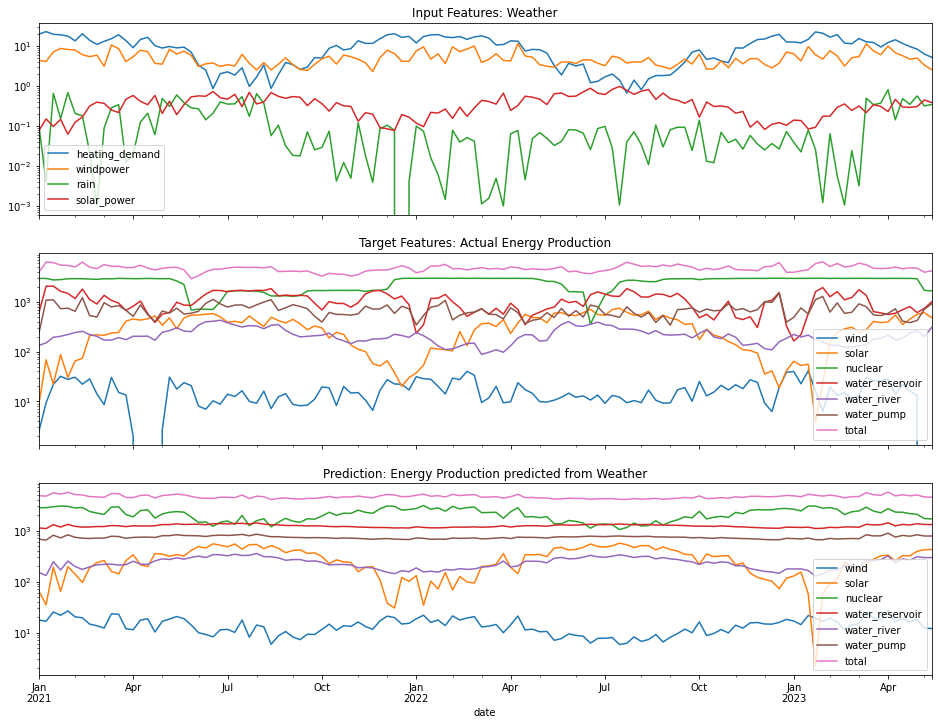

In [28]:
fig,axes = plt.subplots(3,1,figsize=(16,12),sharex=True)

ax = axes[0]
input_features_weekly.plot(ax=ax)
ax.set_yscale("log")
ax.set_title("Input Features: Weather")

ax = axes[1]
target_features_weekly.plot(ax=ax)
ax.set_yscale("log")
ax.set_title("Target Features: Actual Energy Production")


ax = axes[2]
prediction_weekly.plot(ax=ax)
ax.set_yscale("log")
ax.set_title("Prediction: Energy Production predicted from Weather")

### Superimposing with predicted Production and actual Production per Production-Type

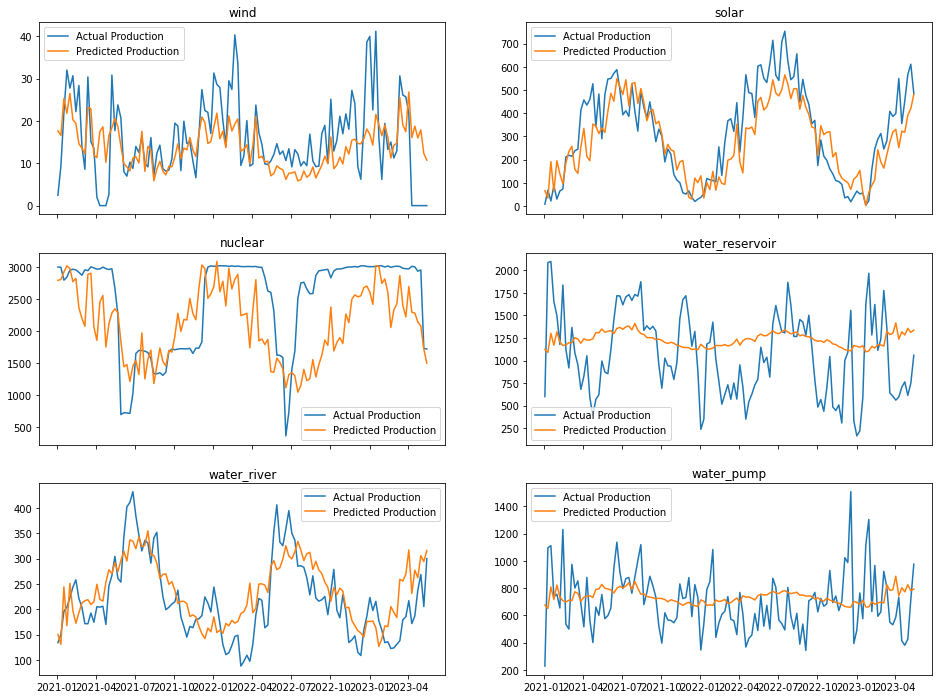

In [60]:
fig,axes = plt.subplots(3,2,figsize=(16,12),sharex=True)

for ax, col in zip(axes.ravel(),target_features.columns):
    ax.plot(target_features_weekly.loc[:,col], label="Actual Production")
    ax.plot(prediction_weekly.loc[:,col], label="Predicted Production")
    ax.set_title(col)
    ax.legend()

fig.savefig("../../src/sp_project/backend_server/static/pictures/overlap.png")

### Store the Model in a file

In [37]:
if False:

    import pickle
    # Short-term-Storage of our model

    with open("prediction-model.pickle", "wb") as fh:
        pickle.dump(dict(
            regressor = pls2,
            input_columns = input_features_columns,
            prediction_columns = target_features_columns,
        ), fh)